In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn.metrics import roc_auc_score, top_k_accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from datasets import ClassLabel, Features, Value, load_dataset, load_metric, DatasetDict, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          BertTokenizer, DataCollatorWithPadding, RobertaTokenizer)
from transformers import TrainingArguments, Trainer

from sklearn.metrics import f1_score, top_k_accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

In [3]:
def load_robeczech(ROBECZECH_MODEL='ufal/robeczech-base', n_classes=64):
    
    config = AutoConfig.from_pretrained(ROBECZECH_MODEL, num_labels=n_classes)
    tokenizer = RobertaTokenizer.from_pretrained(ROBECZECH_MODEL)

    model = AutoModelForSequenceClassification.from_pretrained(ROBECZECH_MODEL, config=config)
    
    return model, tokenizer

model, tokenizer = load_robeczech('intent_detector/robeczech-best')

In [4]:
from intent_detector.clf import preprocess_dataset, load_merged_banking, compute_metrics_merged,preprocess_dataset
banking_dir = '/home/sfabo/ni-dip/data_text2bank/merged-2022-03-24.csv'
dataset = load_merged_banking(banking_dir)

tokenized_dataset = preprocess_dataset(dataset, tokenizer)

  0%|          | 0/9 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [8]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

trainer = Trainer(model=model,     eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_merged,)

test_metrics = trainer.evaluate()

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text_cz, kategorie. If text_cz, kategorie are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1036
  Batch size = 16
/home/sfabo/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but al

/home/sfabo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/sfabo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [17]:
tm = pd.Series(test_metrics)
tm.index = tm.index.str.replace('^eval_', '')
tm = tm * 100
print(tm.to_latex(float_format='%.2f'))

\begin{tabular}{lr}
\toprule
{} &        0 \\
\midrule
loss               &    64.21 \\
f1                 &    90.60 \\
acc\_bal            &    90.85 \\
acc                &    90.64 \\
acc\_top\_3          &    97.30 \\
b77\_f1             &    90.47 \\
b77\_acc\_bal        &    90.26 \\
b77\_acc            &    90.36 \\
t2b\_f1             &    97.46 \\
t2b\_acc\_bal        &    96.42 \\
t2b\_acc            &    96.30 \\
runtime            &   447.69 \\
samples\_per\_second & 23140.90 \\
steps\_per\_second   &  1451.90 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2721821/147460194.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tm.index = tm.index.str.replace('^eval_', '')
/tmp/ipykernel_2721821/147460194.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tm.to_latex(float_format='%.2f'))


In [6]:
tokenized_dataset = preprocess_dataset(dataset, tokenizer)

test_prediction = trainer.predict(tokenized_dataset['test'])

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text_cz, kategorie. If text_cz, kategorie are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1036
  Batch size = 16
/home/sfabo/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sfabo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/sfabo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred co

In [7]:
from sklearn.metrics import classification_report
import pandas as pd

cats = pd.read_csv(banking_dir)['kategorie'].unique()

print(classification_report(tokenized_dataset['test']['labels'], test_prediction.predictions.argmax(axis=1), target_names=cats))
# test_prediction.predictions.argmax(axis=1)
# len(tokenized_dataset['test']['labels'])

                                                          precision    recall  f1-score   support

                                    aktivovat moji kartu       1.00      0.95      0.97        20
                           bezkontaktní platba nefunguje       1.00      1.00      1.00         8
                                         karta nefunguje       0.78      0.93      0.85        15
                                         karta spolknuta       1.00      0.90      0.95        10
                                         zablokovaný pin       0.79      1.00      0.88        15
                                          karta zneužita       1.00      0.67      0.80        12
                              limity jednorázových karet       0.88      0.88      0.88        16
                                     délka doby převodu        0.87      0.76      0.81        17
          nesprávná částka přijaté hotovosti z bankomatu       1.00      0.95      0.98        22
                   

In [18]:
!pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached matplotlib-3.5.1-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.3 MB)
  Using cached scipy-1.8.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.6 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 900.8/900.8 KB 19.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 62.8 MB/s eta 0:00:00a 0:00:01


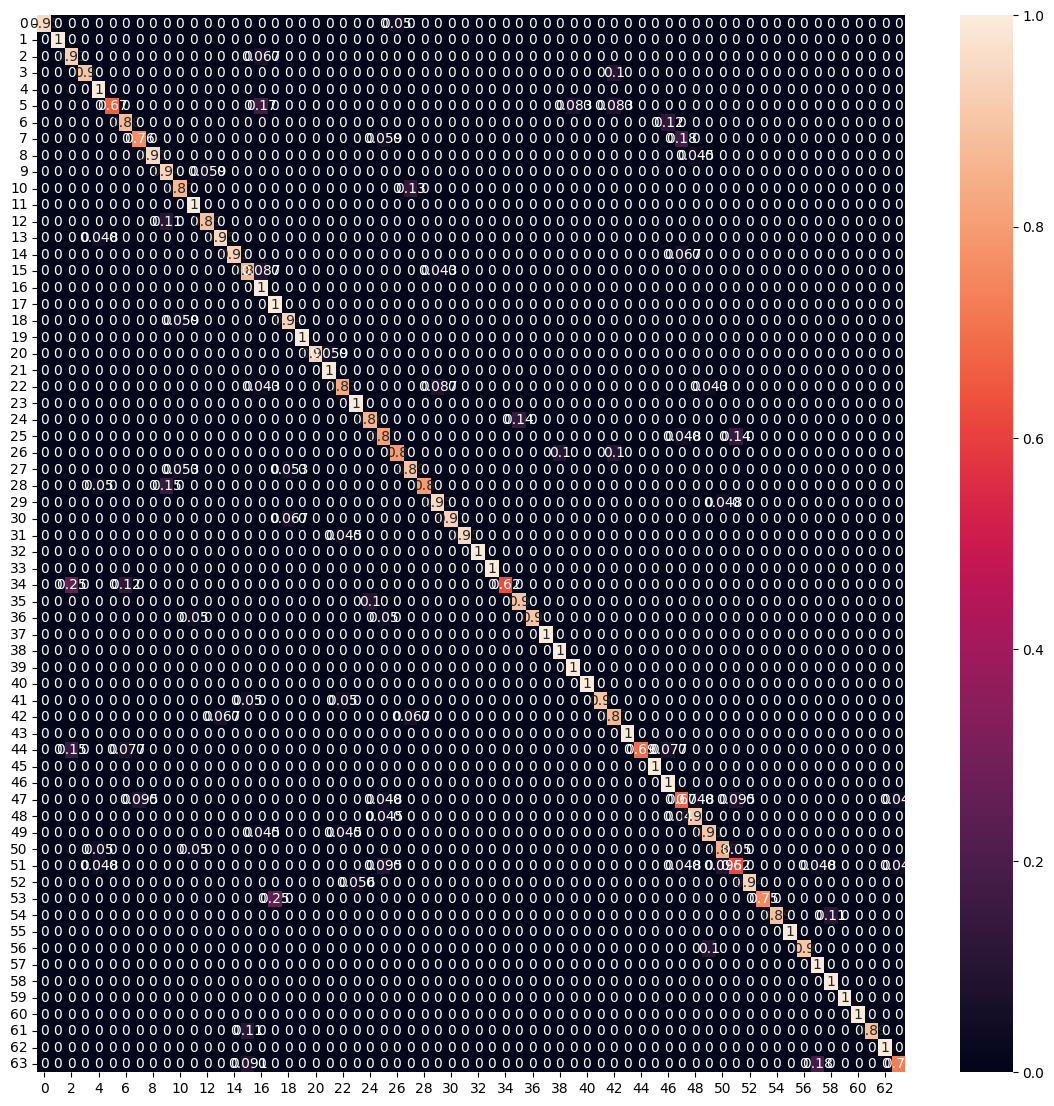

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,14), dpi=100)
sns.heatmap(confusion_matrix(tokenized_dataset['test']['labels'], test_prediction.predictions.argmax(axis=1), normalize='true'), annot=True)
plt.show()

In [24]:
import pandas as pd

d = [{
    "name": 'CZERT',
      "epoch": 16.52,
      "learning_rate": 9.67511013215859e-07,
      "loss": 0.5502,
      "step": 7500,
      "epoch": 17.0,
      "eval_acc": 0.9009009009009009,
      "eval_acc_bal": 0.9007915146853194,
      "eval_acc_top_3": 0.9787644787644788,
      "eval_b77_acc": 0.8988684582743989,
      "eval_b77_acc_bal": 0.8976956549031271,
      "eval_b77_f1": 0.8993597570473882,
      "eval_f1": 0.9003742356640608,
      "eval_loss": 0.5312461256980896,
      "eval_runtime": 6.4053,
      "eval_samples_per_second": 242.612,
      "eval_steps_per_second": 15.3,
      "eval_t2b_acc": 0.9105691056910569,
      "eval_t2b_acc_bal": 0.9083435083435085,
      "eval_t2b_f1": 0.9288766416104242,
      "step": 7718
    },{
    "name": 'FERNET',
      "epoch": 14.48,
      "learning_rate": 1.1956241956241956e-06,
      "loss": 0.5554,
      "step": 7500,
      "epoch": 15.0,
      "eval_acc": 0.8918918918918919,
      "eval_acc_bal": 0.8895319763405874,
      "eval_acc_top_3": 0.972972972972973,
      "eval_b77_acc": 0.8919491525423728,
      "eval_b77_acc_bal": 0.889791358416379,
      "eval_b77_f1": 0.8916074915180207,
      "eval_f1": 0.8905813678564242,
      "eval_loss": 0.5502132177352905,
      "eval_runtime": 5.2046,
      "eval_samples_per_second": 199.054,
      "eval_steps_per_second": 12.489,
      "eval_t2b_acc": 0.8888888888888888,
      "eval_t2b_acc_bal": 0.8858024691358025,
      "eval_t2b_f1": 0.8809577254021697,
      "step": 7770
    },    {
      'name': 'ROBECZECH',
      "epoch": 30.89,
      "learning_rate": 1.0347490347490346e-06,
      "loss": 0.622,
      "step": 16000,
      "epoch": 31.0,
      "eval_acc": 0.9256756756756757,
      "eval_acc_bal": 0.9282763154460536,
      "eval_acc_top_3": 0.972972972972973,
      "eval_b77_acc": 0.9226694915254238,
      "eval_b77_acc_bal": 0.9234818059607548,
      "eval_b77_f1": 0.9224413170297836,
      "eval_f1": 0.9245949010145886,
      "eval_loss": 0.6129915714263916,
      "eval_runtime": 4.1125,
      "eval_samples_per_second": 251.918,
      "eval_steps_per_second": 15.806,
      "eval_t2b_acc": 0.9506172839506173,
      "eval_t2b_acc_bal": 0.949074074074074,
      "eval_t2b_f1": 0.9564270152505446,
      "step": 16058
    },{
      "name": 'PAVLOV',
      "epoch": 19.31,
      "learning_rate": 1.3967181467181466e-06,
      "loss": 0.6833,
      "step": 10000,
      "epoch": 20.0,
      "eval_acc": 0.8938223938223938,
      "eval_acc_bal": 0.8964012846182017,
      "eval_acc_top_3": 0.9613899613899614,
      "eval_b77_acc": 0.8919491525423728,
      "eval_b77_acc_bal": 0.8932376616799337,
      "eval_b77_f1": 0.8923113141231556,
      "eval_f1": 0.892811430606664,
      "eval_loss": 0.6650875806808472,
      "eval_runtime": 5.548,
      "eval_samples_per_second": 186.734,
      "eval_steps_per_second": 11.716,
      "eval_t2b_acc": 0.9259259259259259,
      "eval_t2b_acc_bal": 0.924074074074074,
      "eval_t2b_f1": 0.9254460505922494,
      "step": 10360
    },]

r = pd.DataFrame(d).drop(columns=['learning_rate', 'step', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second'])

cols = r.columns[r.columns.str.contains('acc|f1', regex=True)]

r[cols] = r[cols] * 100

print(r)

r = r.reindex(columns=['name', 'epoch', 'loss', 'eval_loss', 'eval_f1', 'eval_acc', 'eval_acc_bal', 'eval_acc_top_3',
       'eval_b77_acc', 'eval_b77_acc_bal', 'eval_b77_f1',
        'eval_t2b_acc', 'eval_t2b_acc_bal', 'eval_t2b_f1'])

r

a = [
    ['set', 'overall','overall','overall', 'full', 'full', 'full',  'full', 'B77', 'B77', 'B77',  'T2B', 'T2B', 'T2B'],
    ['name', 'epoch', 'loss', 'eval_loss', 'acc', 'acc_bal', 'acc_top_3', 'f1', 'b77_acc', 'b77_acc_bal', 'b77_f1',  't2b_acc', 't2b_acc_bal', 't2b_f1'], 
    ]

tuples = list(zip(*a))
index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
r.columns = index

# print(r.to_latex(index=False, float_format='%.2f'))

        name  epoch    loss   eval_acc  eval_acc_bal  eval_acc_top_3  \
0      CZERT   17.0  0.5502  90.090090     90.079151       97.876448   
1     FERNET   15.0  0.5554  89.189189     88.953198       97.297297   
2  ROBECZECH   31.0  0.6220  92.567568     92.827632       97.297297   
3     PAVLOV   20.0  0.6833  89.382239     89.640128       96.138996   

   eval_b77_acc  eval_b77_acc_bal  eval_b77_f1    eval_f1  eval_loss  \
0     89.886846         89.769565    89.935976  90.037424   0.531246   
1     89.194915         88.979136    89.160749  89.058137   0.550213   
2     92.266949         92.348181    92.244132  92.459490   0.612992   
3     89.194915         89.323766    89.231131  89.281143   0.665088   

   eval_t2b_acc  eval_t2b_acc_bal  eval_t2b_f1  
0     91.056911         90.834351    92.887664  
1     88.888889         88.580247    88.095773  
2     95.061728         94.907407    95.642702  
3     92.592593         92.407407    92.544605  


In [25]:
print(r[['set', 'full']].to_latex(index=False, float_format='%.2f'))

\begin{tabular}{lrrrr}
\toprule
      set & \multicolumn{4}{l}{full} \\
     name &   acc & acc\_bal & acc\_top\_3 &    f1 \\
\midrule
    CZERT & 90.04 &   90.09 &     90.08 & 97.88 \\
   FERNET & 89.06 &   89.19 &     88.95 & 97.30 \\
ROBECZECH & 92.46 &   92.57 &     92.83 & 97.30 \\
   PAVLOV & 89.28 &   89.38 &     89.64 & 96.14 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2721821/1514883188.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(r[['set', 'full']].to_latex(index=False, float_format='%.2f'))


In [26]:
print(r[['set', 'B77', 'T2B']].to_latex(index=False, float_format='%.2f'))

\begin{tabular}{lrrrrrr}
\toprule
      set & \multicolumn{3}{l}{B77} & \multicolumn{3}{l}{T2B} \\
     name & b77\_acc & b77\_acc\_bal & b77\_f1 & t2b\_acc & t2b\_acc\_bal & t2b\_f1 \\
\midrule
    CZERT &   89.89 &       89.77 &  89.94 &   91.06 &       90.83 &  92.89 \\
   FERNET &   89.19 &       88.98 &  89.16 &   88.89 &       88.58 &  88.10 \\
ROBECZECH &   92.27 &       92.35 &  92.24 &   95.06 &       94.91 &  95.64 \\
   PAVLOV &   89.19 &       89.32 &  89.23 &   92.59 &       92.41 &  92.54 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2721821/733490520.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(r[['set', 'B77', 'T2B']].to_latex(index=False, float_format='%.2f'))


In [13]:
print(r[['set', 'overall']].to_latex(index=False, float_format='%.2f'))

\begin{tabular}{lrrr}
\toprule
      set & \multicolumn{3}{l}{overall} \\
     name &   epoch & loss & eval\_loss \\
\midrule
    CZERT &   17.00 & 0.55 &      0.53 \\
   FERNET &   15.00 & 0.56 &      0.55 \\
ROBECZECH &   33.00 & 0.53 &      0.54 \\
   PAVLOV &   20.00 & 0.68 &      0.67 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2558837/3622838854.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(r[['set', 'overall']].to_latex(index=False, float_format='%.2f'))
